# Claim triage notebook

Claim payments and claim adjustments are typically an insurance company’s largest expenses. For long-tail lines of business, such as workers’ compensation (which covers medical expenses and lost wages for injured workers), claims can take years to be paid in full; therefore, the true cost of a claim may not be known for many years. However, claim adjustment activities start when a claim is made aware to the insurer.

This notebook aims to outline a workflow for evaluating the severity of an insurance claim in order to triage it effectively.

Download the sample training data [here](https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Statistical_Case_Estimates.csv).

## Setup

### Import libraries

In [1]:
import datetime
import os

import datarobot as dr
import pandas as pd

### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [ ]:
# If the config file is not in the default location described in the API Quickstart guide, '~/.config/datarobot/drconfig.yaml', then you will need to call
# dr.Client(config_path='path-to-drconfig.yaml')

### Import data

In [3]:
df = pd.read_csv(
    "https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Statistical_Case_Estimates.csv"
)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21691 entries, 0 to 21690
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ReportingDelay       21691 non-null  int64  
 1   AccidentHour         21691 non-null  int64  
 2   Age                  21691 non-null  int64  
 3   WeeklyRate           21691 non-null  float64
 4   Gender               21691 non-null  object 
 5   MaritalStatus        21669 non-null  object 
 6   HoursWorkedPerWeek   21691 non-null  float64
 7   DependentChildren    21691 non-null  int64  
 8   DependentsOther      21691 non-null  int64  
 9   PartTimeFullTime     21691 non-null  object 
 10  DaysWorkedPerWeek    21691 non-null  int64  
 11  DateOfAccident       21691 non-null  object 
 12  ClaimDescription     21691 non-null  object 
 13  ReportedDay          21691 non-null  object 
 14  InitialCaseEstimate  21691 non-null  int64  
 15  Incurred             21691 non-null 

ReportingDelay  AccidentHour  Age  WeeklyRate Gender MaritalStatus  \
0              15            11   28      500.00      M             S   
1              22             5   29      500.00      M             S   
2              22             7   28      197.37      M             M   
3              15            12   40        0.00      M             M   
4              38            12   22      435.70      M             M   

   HoursWorkedPerWeek  DependentChildren  DependentsOther PartTimeFullTime  \
0                44.0                  0                0                F   
1                38.0                  0                0                F   
2                16.0                  0                0                P   
3                 0.0                  1                0                F   
4                38.0                  0                0                F   

   DaysWorkedPerWeek DateOfAccident  \
0                  5      5/10/2005   
1                  5     28/10/2003   
2                  3     25/05/2004   
3                  5     21/07/1994   
4                  5      9/06/1992   

                                    ClaimDescription ReportedDay  \
0               STRUCK SCAFFOLDING STRAIN LOWER BACK      3Thurs   
1                  STRUCK KNIFE LACERATED LEFT THUMB        2Wed   
2  SLIPPED AND HIT STRAINED LEFT SHOULDER INJURY ...        2Wed   
3  HIT FALLING DOOR LACERATION LEFT SHOULDER INJU...        4Fri   
4  STRUCK FALLING OBJECT LACERATION RIGHT RING FI...        4Fri   

   InitialCaseEstimate     Incurred  
0                 9500   151.254501  
1                11500   442.125024  
2                 8000  1494.490505  
3                  500   138.900000  
4                  320   296.160000

### Check the distribution of the target feature

The histogram below shows the distribution of the target, `Incurred`. You can observe that most claims are closed with a small payment; the median is less than $500, and the 75th percentile is $1820. This right-skewed distribution represents a typical distribution of insurance claims. This is often modeled by Gamma distribution. Autopilot automatically detects the target's distribution and recommends the appropriate optimization metric accordingly. 

In this example, DataRobot recommends Gamma Deviance, which is used for modeling in this use case. Besides Gamma Deviance, DataRobot also includes a list of metrics that you can select based on your own needs.

In [4]:
df["Incurred"].describe()

count    2.169100e+04
mean     9.647973e+03
std      4.713051e+04
min      2.220000e-15
25%      1.802750e+02
50%      4.959266e+02
75%      1.827121e+03
max      1.563323e+06
Name: Incurred, dtype: float64

<AxesSubplot:>

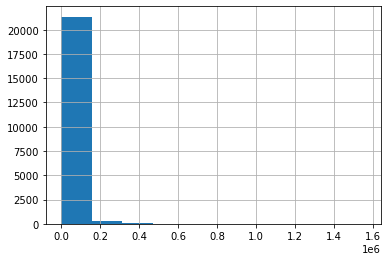

In [12]:
df["Incurred"].hist(bins=10)

### Feature engineering

Feature engineering has proven to improve model performance in many use cases, although it is an optional step for this workflow. This provides an opportunity to incorporate domain knowledge into the model. Feature engineering can be as simple as extracting the month from a date so that a seasonal trend can be captured. Alternatively, it can be as complicated as getting aggregated claim counts for the past x years. Therefore depending on the use case, feature engineering can be very time-consuming. For illustration purposes, feature engineering is already performed on the example dataset. 

For example, `ReportingDelay` = `ReportDate` - `AccidentDate`. In Python, the following code can be used to achieve this: 

<mark> df["ReportingDelay"] = df["ReportDate"] - df["AccidentDate"] </mark> 

The result above assumes that `ReportDate` and `AccidentDate` are both recorded in the original dataset.

## Modeling

### Create a project

Upload the training data to DataRobot to create a project. In this example, upload the dataframe "df" created in previous steps to DataRobot.

In [13]:
project_name = f"Workers Comp Claim Severity {datetime.datetime.now()}"
project = dr.Project.create(df, project_name=project_name)

### Initiate Autopilot

In [14]:
project.analyze_and_model(target="Incurred", worker_count=-1)

Project(Workers Comp Claim Severity 2022-10-18 13:01:08.535262)

The output for the following snippet displays the features included in the "Informative Features" feature list.

In [15]:
flists = project.get_featurelists()
flist = next(x for x in flists if x.name == "Informative Features")
flist.features

['ReportingDelay',
 'AccidentHour',
 'Age',
 'WeeklyRate',
 'Gender',
 'MaritalStatus',
 'HoursWorkedPerWeek',
 'DependentChildren',
 'DependentsOther',
 'PartTimeFullTime',
 'DaysWorkedPerWeek',
 'DateOfAccident (Year)',
 'ClaimDescription',
 'ReportedDay',
 'InitialCaseEstimate',
 'Incurred',
 'DateOfAccident (Day of Month)',
 'DateOfAccident (Day of Week)',
 'DateOfAccident (Month)']

## Interpret results

Once the data is uploaded to DataRobot, and a project has started, you can start exploring in the GUI. Use the URL below will lead you to the project.

In [9]:
project.open_in_browser

<bound method BrowserMixin.open_in_browser of Project(Workers Comp Claim Severity 2022-10-18 12:55:11.203002)>

### Exploratory Data Analysis

Navigate to the **Data** tab to learn more about your data.

Click each feature to see information such as the summary statistics (min, max, mean, std) of numeric features or a histogram that represents the relationship of a feature with the target.

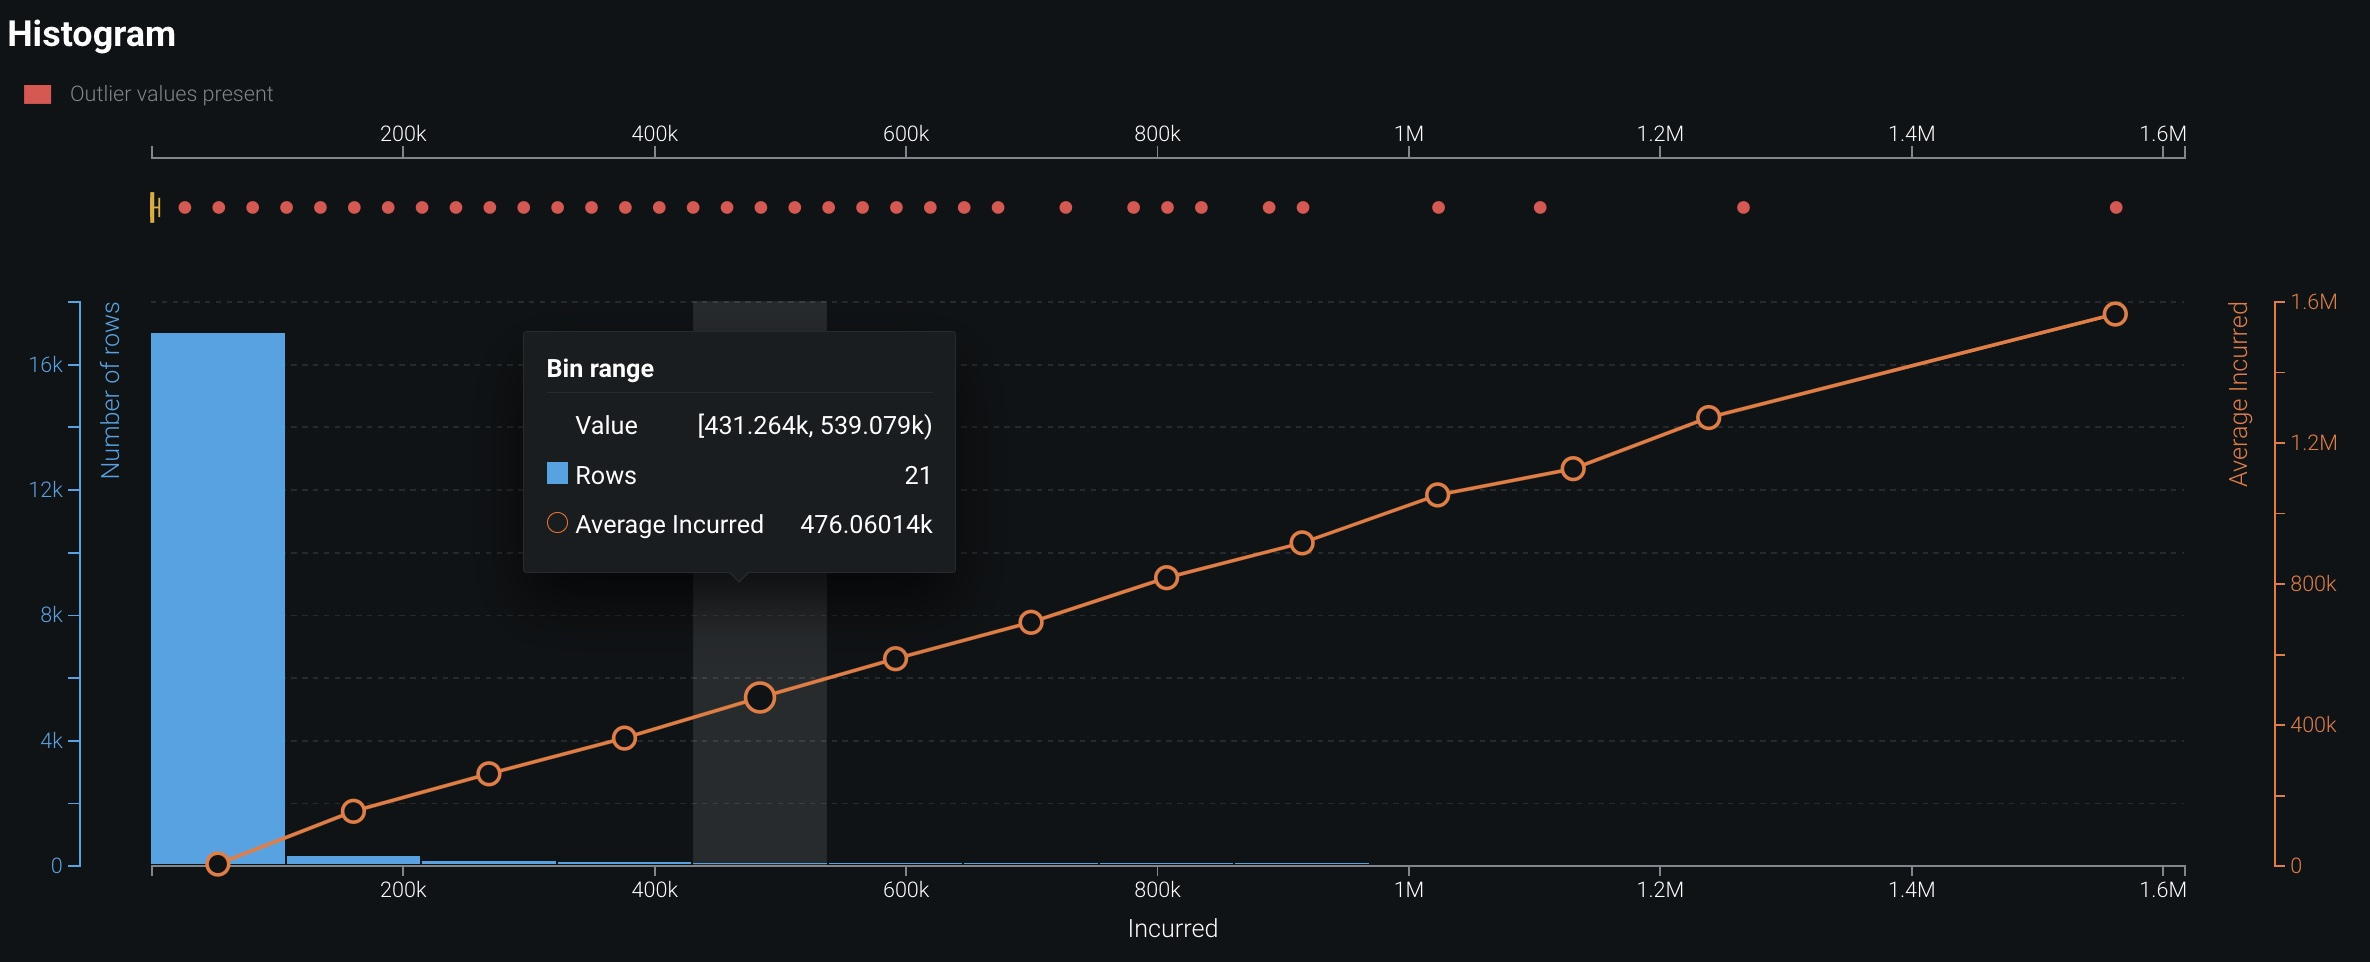

DataRobot automatically performs data quality checks. In this example, it has detected outliers for the target feature. Click 
**Show Outliers** to view them all (outliers are common in insurance claims data). To avoid bias introduced by the outlier, a common practice is to cap the target, such as capping it to the 95th percentile. This cap is especially important for linear models.

### Feature Associations

Use the **Feature Associations** tab to visualize the correlations between each pair of the input features. For example, in the Feature Association plot below, the features `DaysWorkedPerWeek` and `PartTimeFullTime` (top-left corner) have strong associations and are therefore "clustered" together. Each color block in this matrix is a cluster.

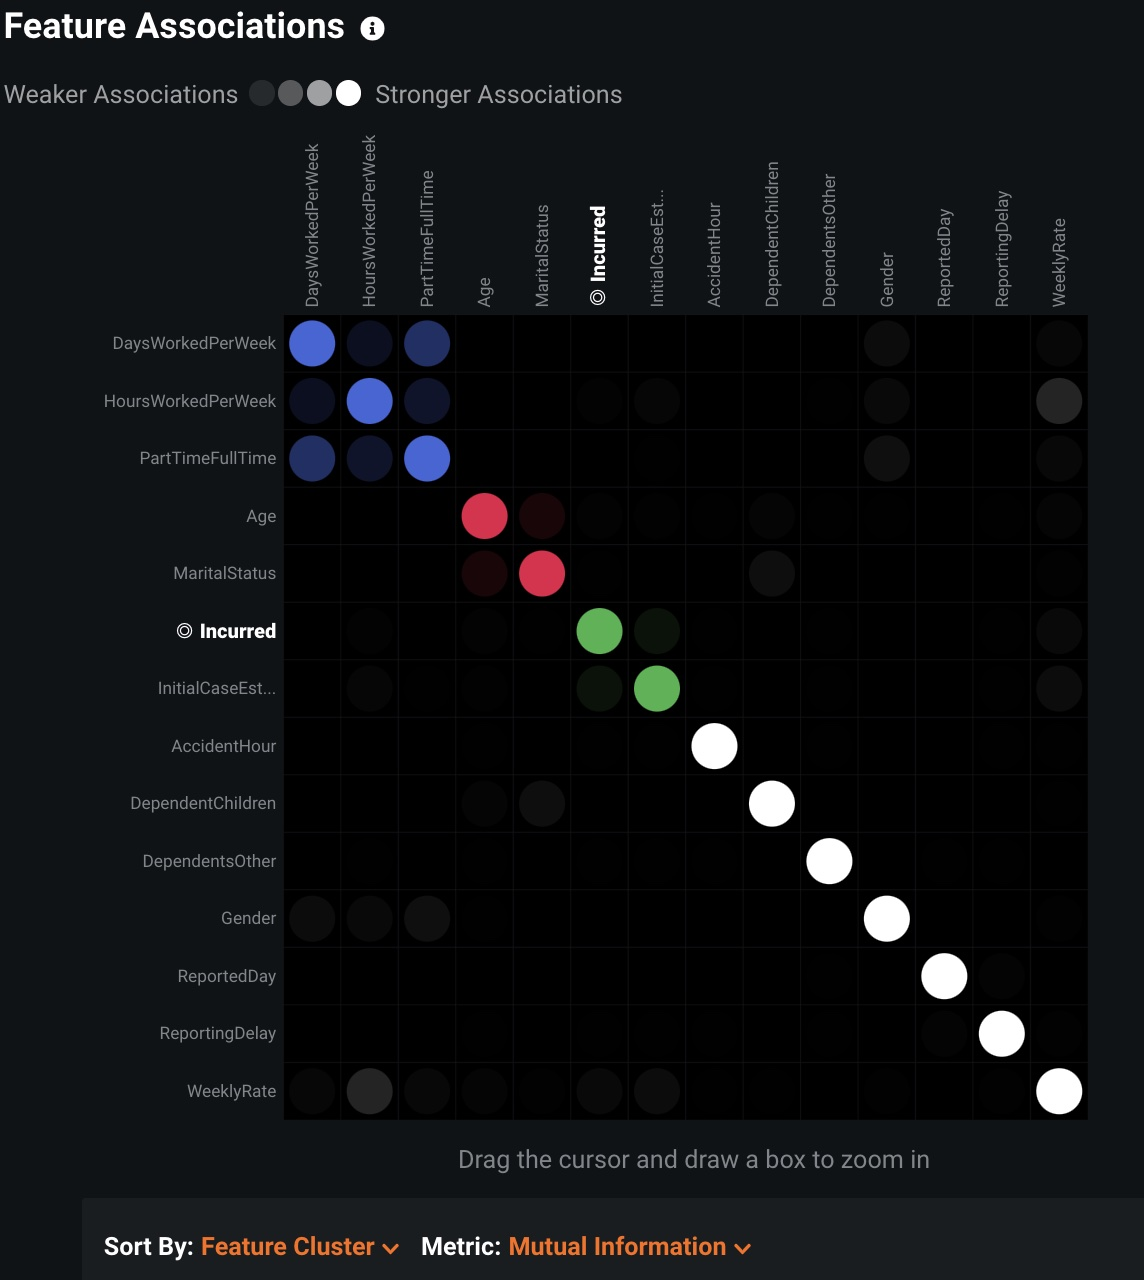

### Leaderboard evaluation

Click the **Models** tab to view models as they build.

Autopilot continues building models until it selects the model that best understands how to predict the target feature, `SAR`. This model is at the top of the Leaderboard, marked with the **Recommended for Deployment** badge. 

Choosing the best model is a balance of accuracy, metric performance, and model simplicity. See the [model recommendation process](https://docs.datarobot.com/en/docs/modeling/reference/model-detail/model-rec-process.html) for more information.

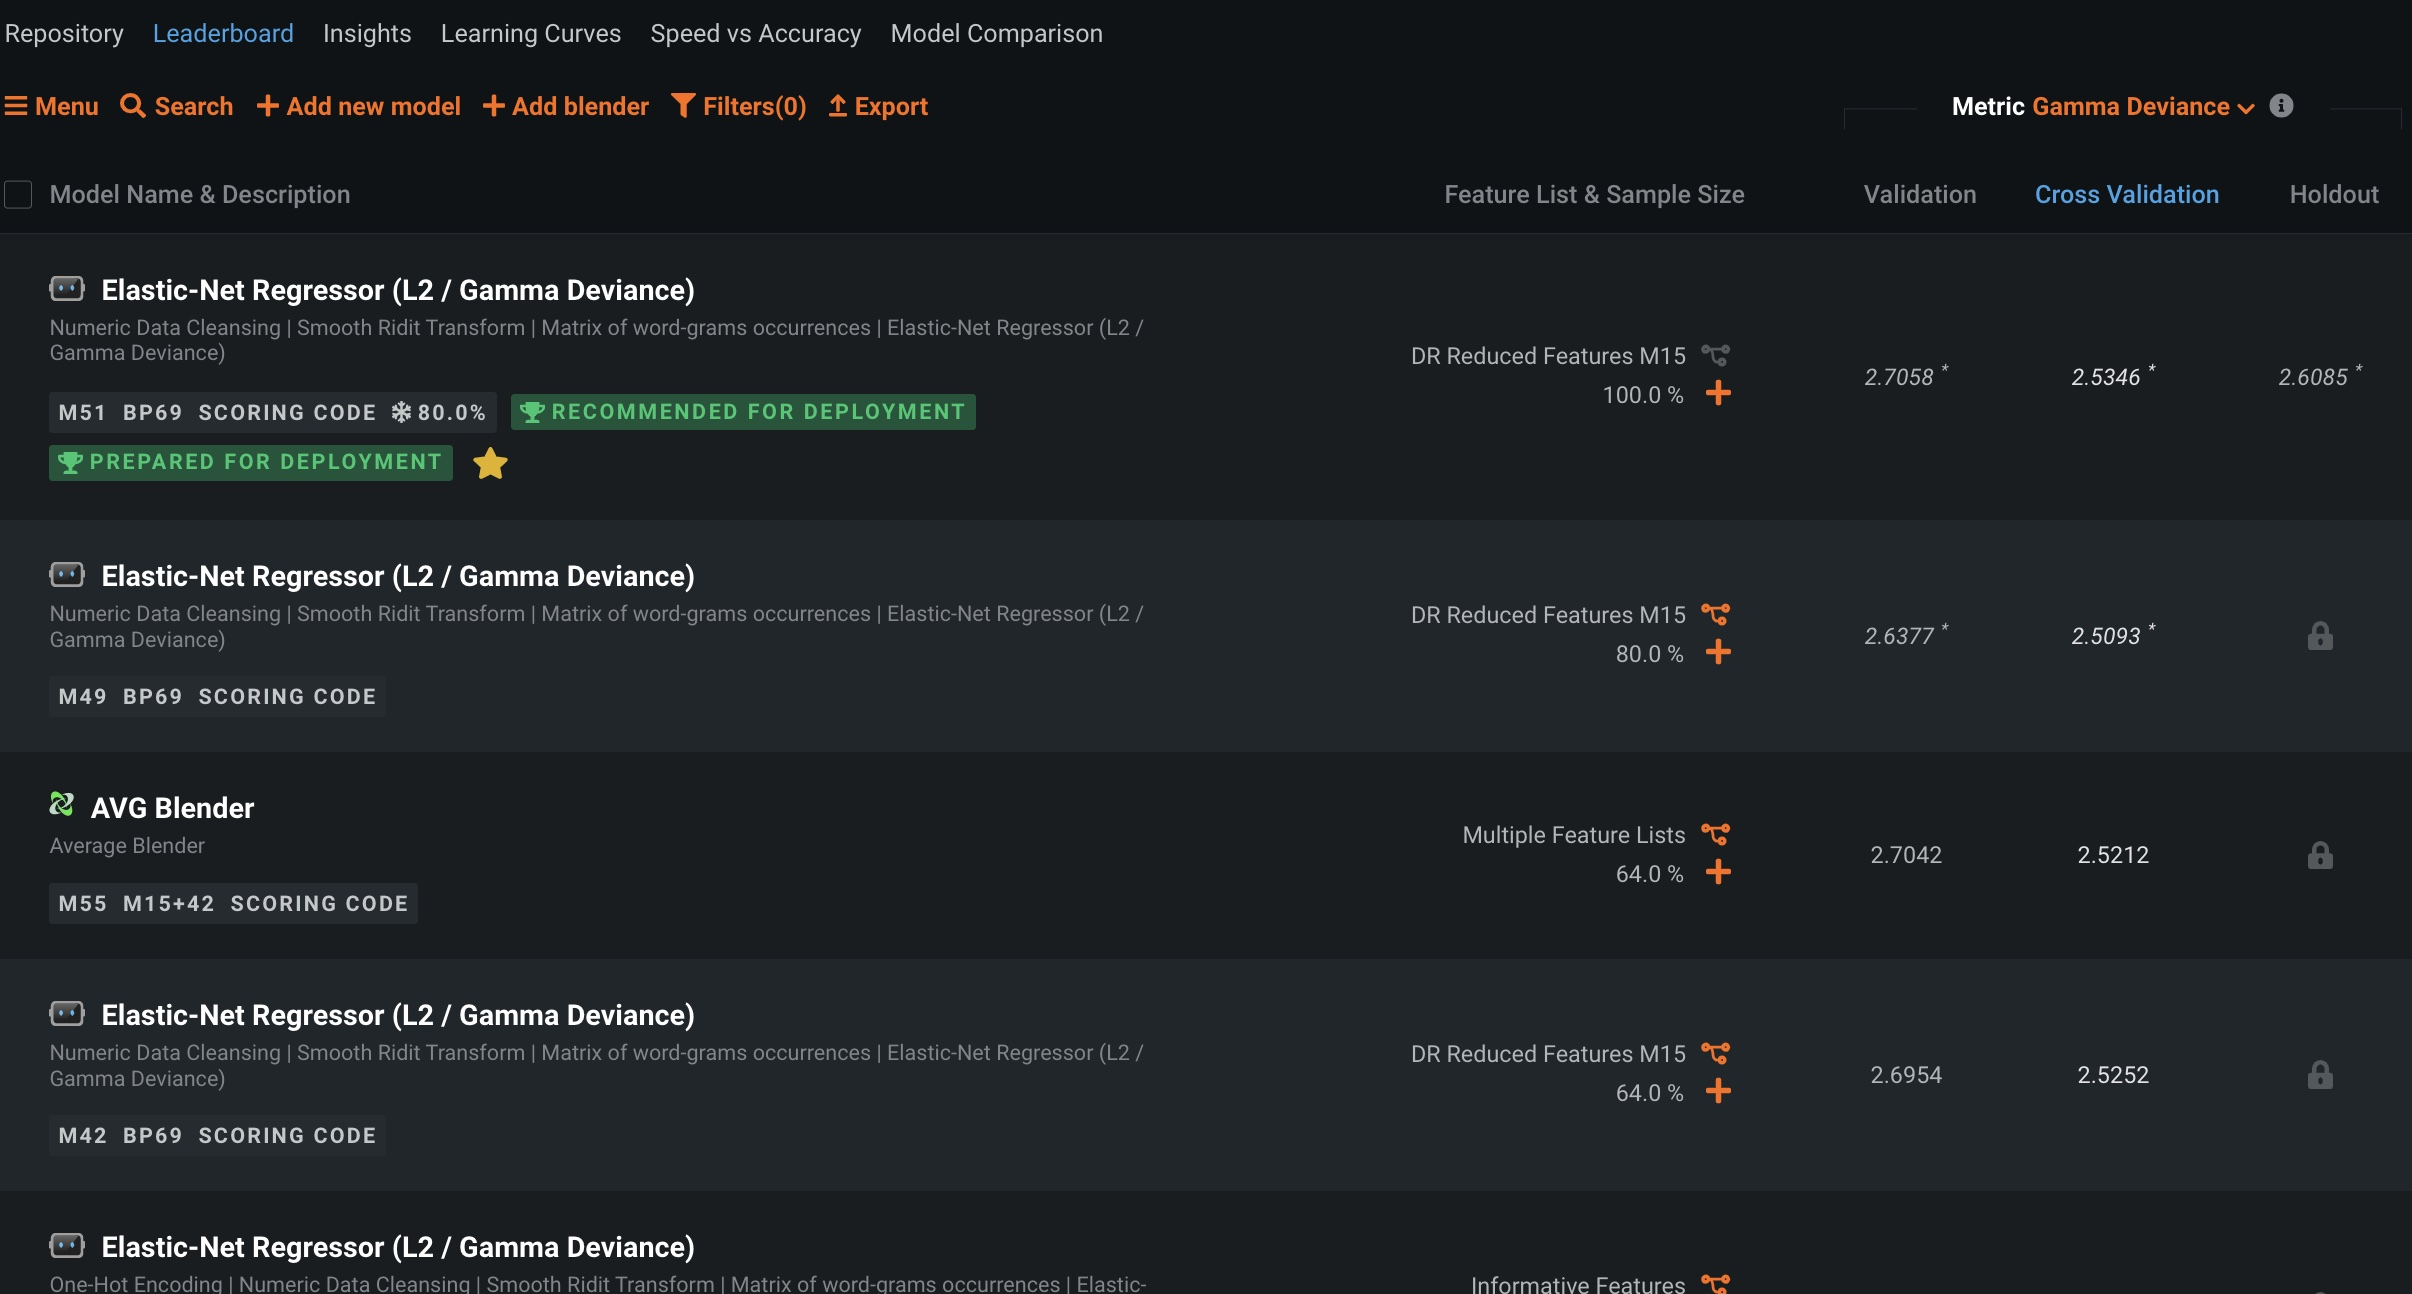

## Model Insights

Select a model on the Leaderboard to view specific model insights.

### Lift Chart

The **Lift Chart** shows how effective the model is and how well the model fit is. To create a lift chart, first sort the predictions from low to high. Then, create a number of equal-sized buckets. For each bucket, the average predicted value and average actual value are calculated and plotted. In the example below, the blue curve represents the average predicted claim cost, and the orange curve indicates the average actual claim cost. The upward slope indicates the model has effectively differentiated the claims of low severity (close to 0) on the left and those of high severity (~45K) on the right. The fact that the actual values (orange curve) closely track the predicted values (blue curve) tells you that the model fits the data well.

Note that DataRobot only displays lift charts on validation or holdout partitions.

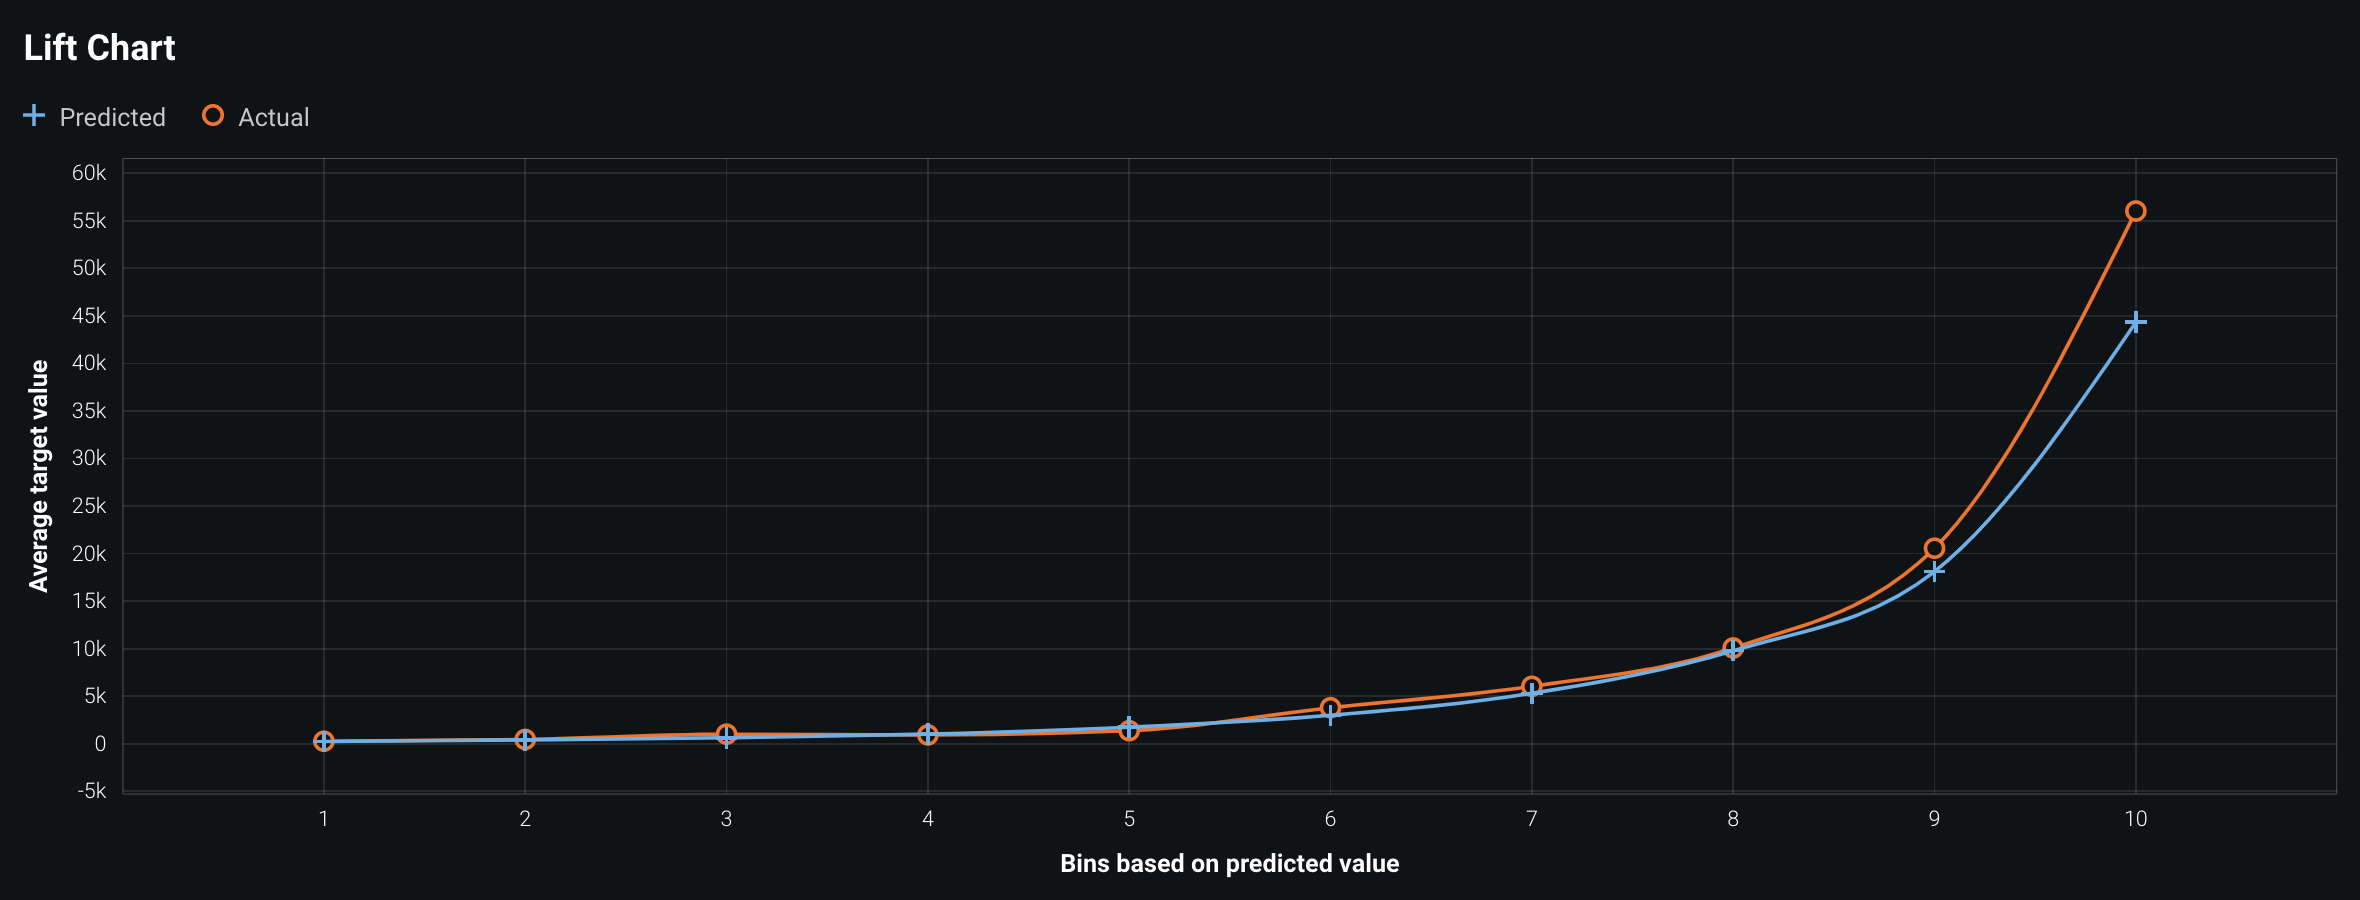

### Feature Impact

Once a model is built, it is helpful to understand which features are driving the model. Feature impact ranks features based on feature importance, from the most important to the least important, and also shows the relative importance of those features. In the example below, you can see that `InitialCaseEstimate` is the most important feature for this model, followed by `ClaimDescription`, `WeeklyRate`, and `Age`.

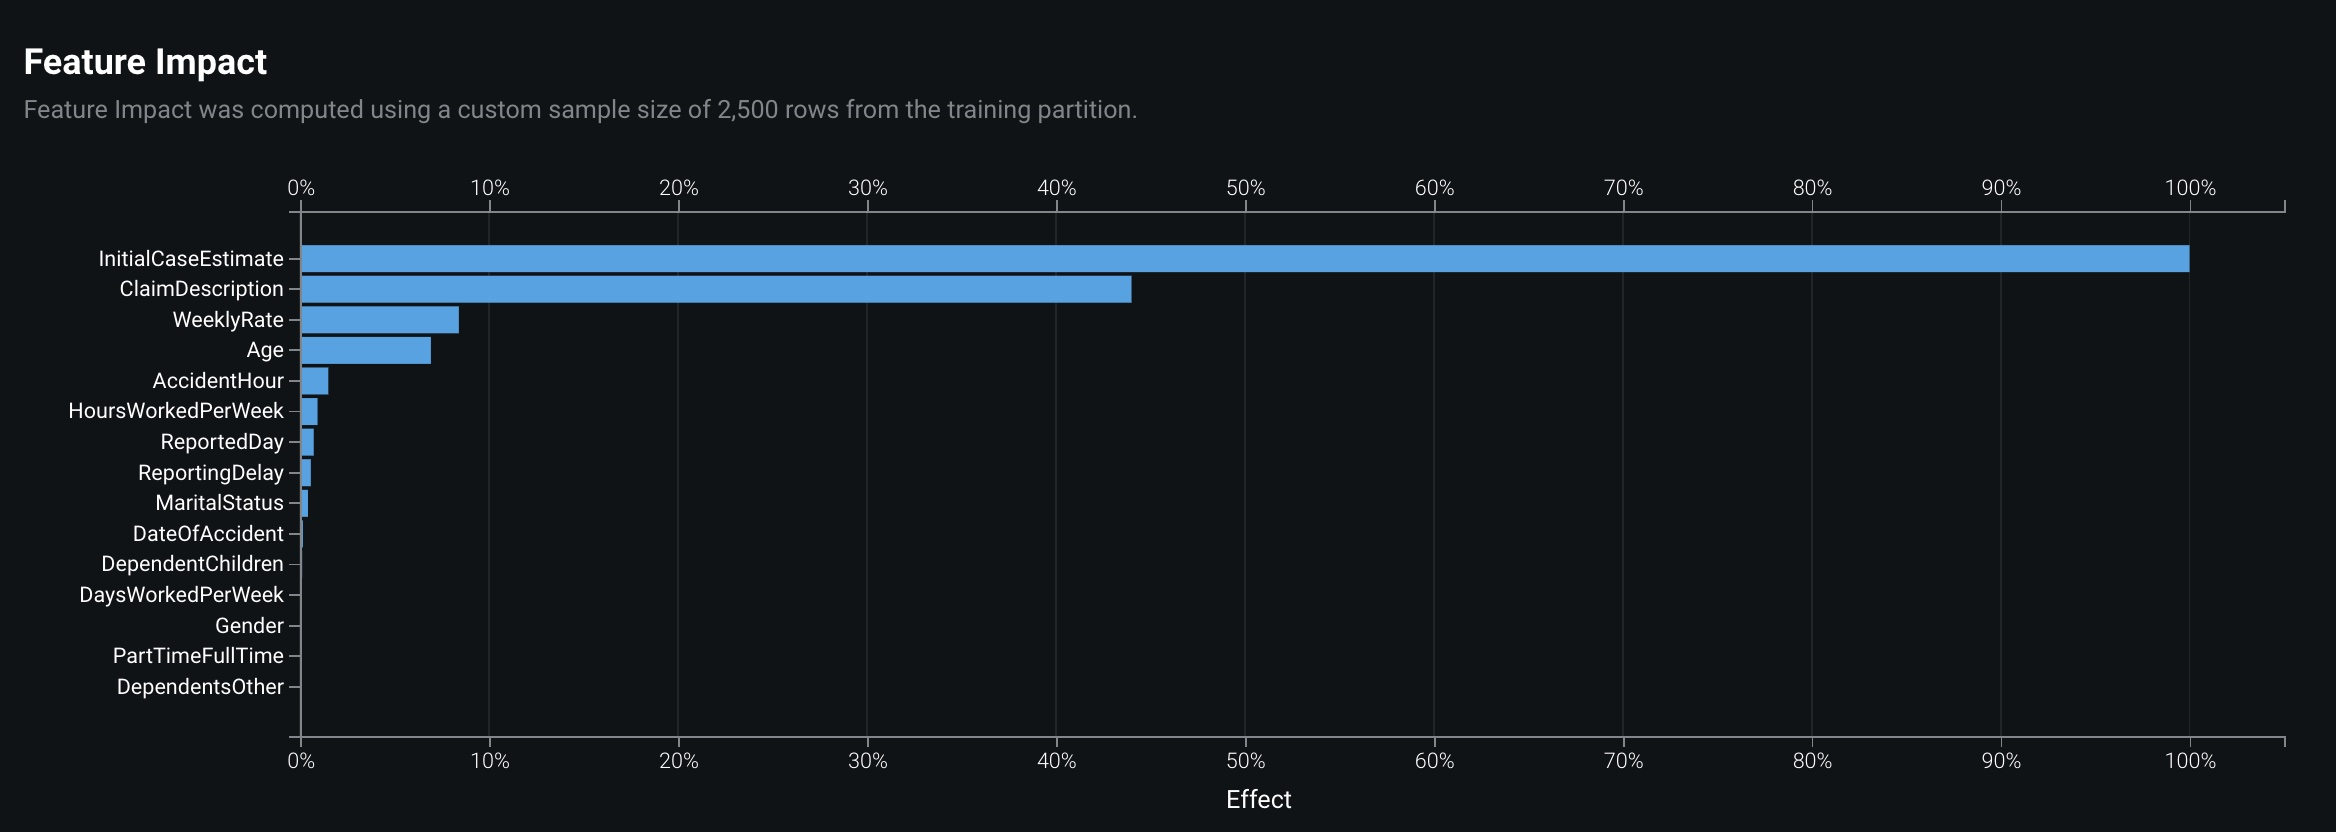

This example indicates that features after `MaritalStatus` have little contribution to the model. For example, gender has minimal contribution to the model, indicating that claim severity doesn't vary by the gender of the claimant. If you create a new feature list that does not include gender (and other features less impactful than `MaritalStatus`) and only includes the most impactful features, the model accuracy should not be significantly impacted. A natural next step is to create a new feature list with only the top features and rerun the model. DataRobot automatically creates a new feature list, "DR Reduced Features", by including features that have a cumulative feature impact of 95%. 

See the [DataRobot documentation](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/feature-impact.html) for more information on feature impact.

### Feature effects

Feature effects indicate how each feature affects predictions. Click on a to see its partial dependence plot. In the example below, notice the partial dependence for the **WeeklyRate** feature. You can observe that claimants with lower weekly pay have lower claim severity, while claimants with higher weekly pay have higher claim severity.

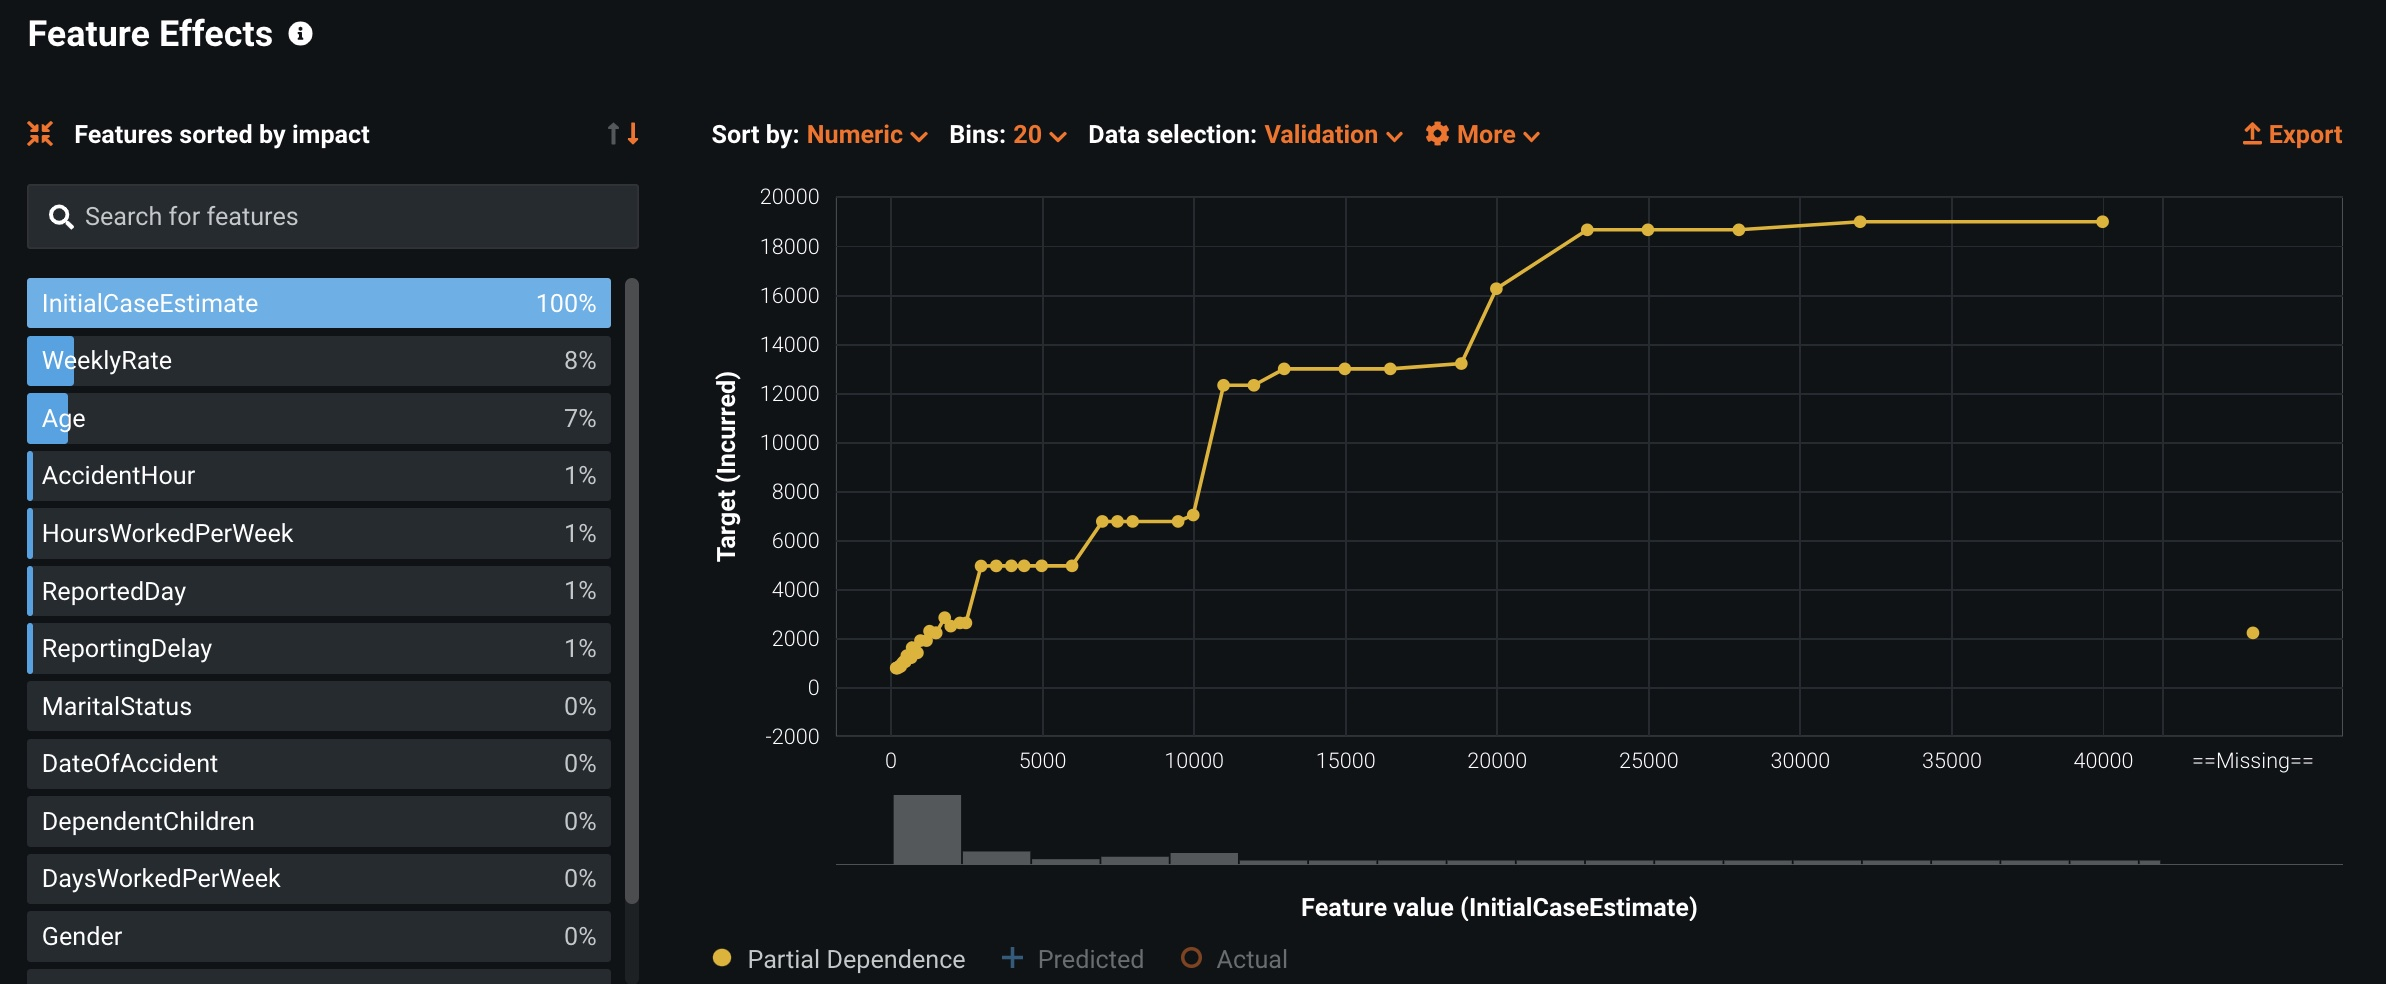

See the [DataRobot documentation](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/feature-effects.html) for more information about feature effects.

### Prediction Explanations

When a claims adjuster sees a low prediction for a claim, they are likely to initially ask what the drivers are behind such a low prediction. Insights provided at an individual prediction level can help claim adjusters understand how a prediction is made to increase confidence in the model. By default, DataRobot provides the top 3 Prediction Explanations for each prediction, but you can request up to 10 explanations. Model predictions and explanations can be downloaded in a CSV file. You can control which predictions are populated in the CSV by specifying the thresholds for high and low predictions. The graph below shows the top three explanations for the 3 highest and lowest predictions. The graph shows that, generally, high predictions are associated with older claimants and higher weekly salary, while the low predictions are associated with a lower weekly salary.

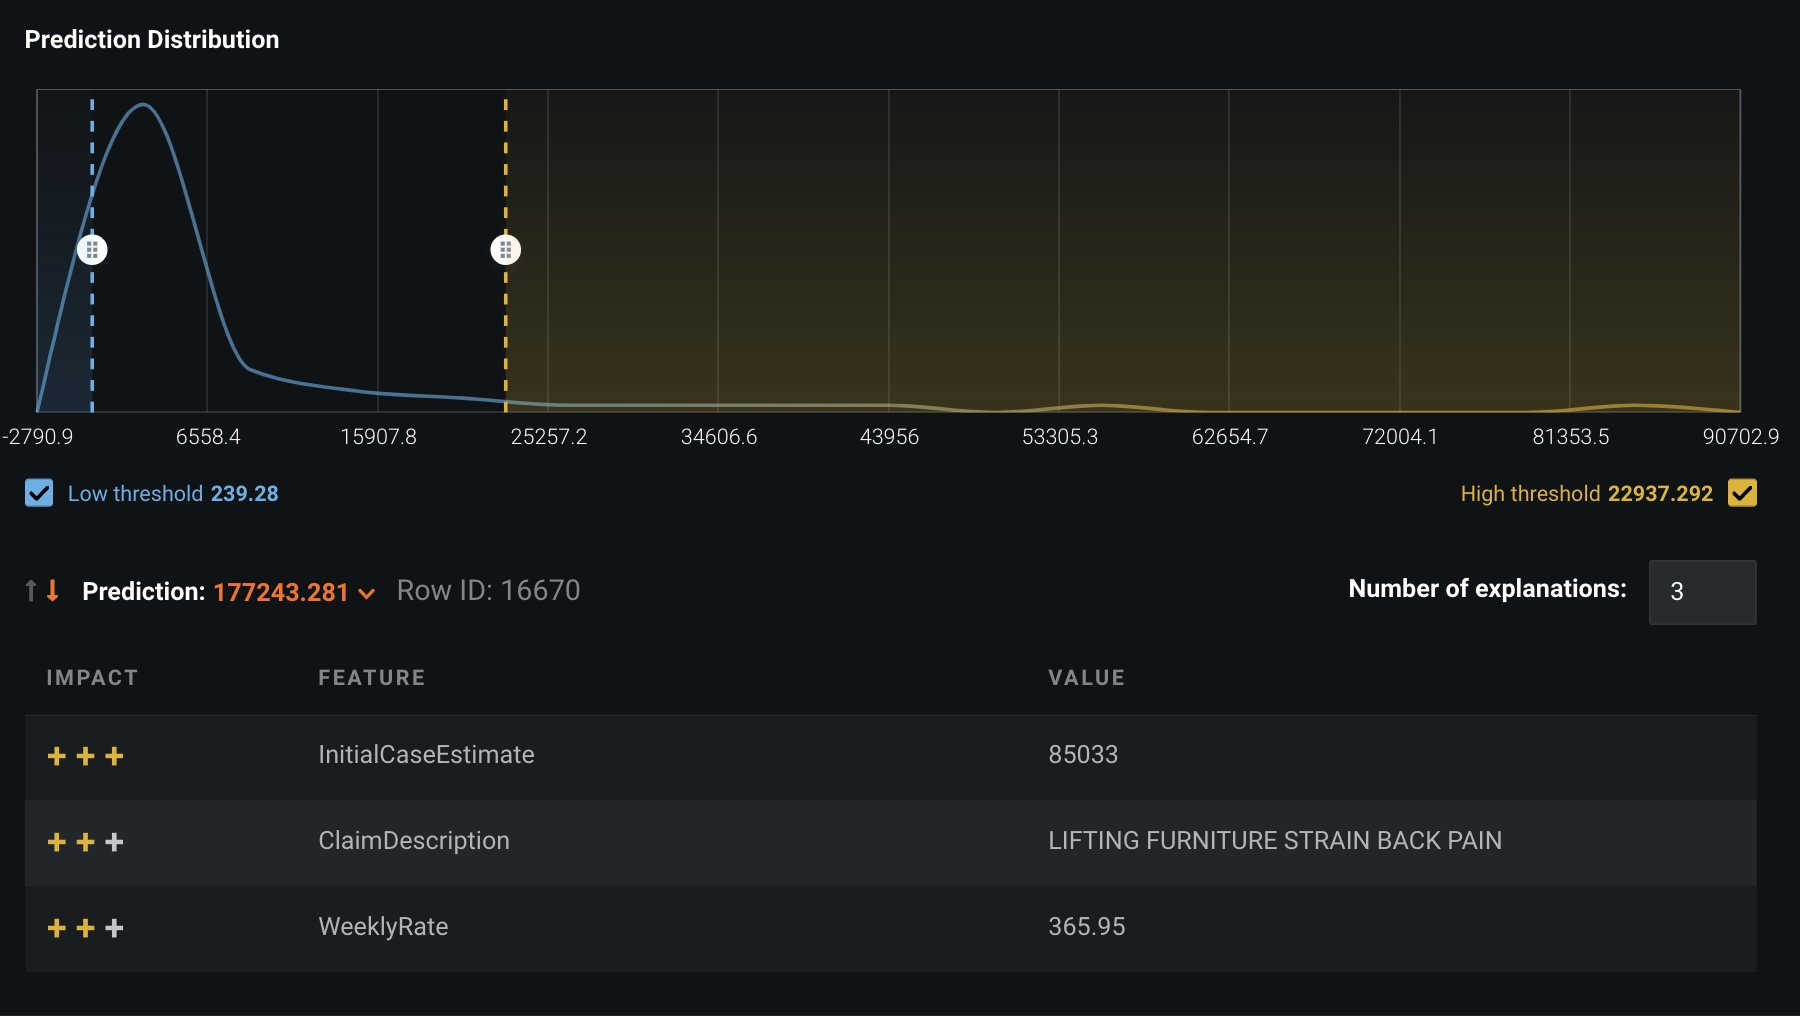

See the [DataRobot documentation](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/pred-explain/index.html) for more information about Prediction Explanations.

### Word Cloud

`ClaimDescription` is an unstructured text field. 

During Autopilot, DataRobot builds text mining models on textual features. The models' outputs are automatically used as inputs in the subsequent modeling processes. Below is a word cloud for the feature `ClaimDescription`, showing the keywords parsed out by DataRobot. The font size of the word indicates how frequently the word appears in the data. You can see that "strain" appears very often in the data while "fractured" does not appear as often. Word color indicates severity. Both "strain" and "fractured" (red) are associated with high-severity claims while "finger" and "eye" (blue) are associated with low-severity claims.

DataRobot can transform and model textual data in sophisticated ways. There are hundreds of blueprints with different methods to transform and manipulate text data. TF-IDF and other transformers are applied to raw text data and are sent to sophisticated models. DataRobot is also multilingual, using automatic language identification for text data and supporting different text mining algorithms, depending on the language it detects. The process of feature engineering free text data is notoriously complex and difficult, so data scientists often avoid doing it manually. DataRobot automatically finds, tunes, and interprets the best text mining algorithms for a dataset, saving both time and resources.

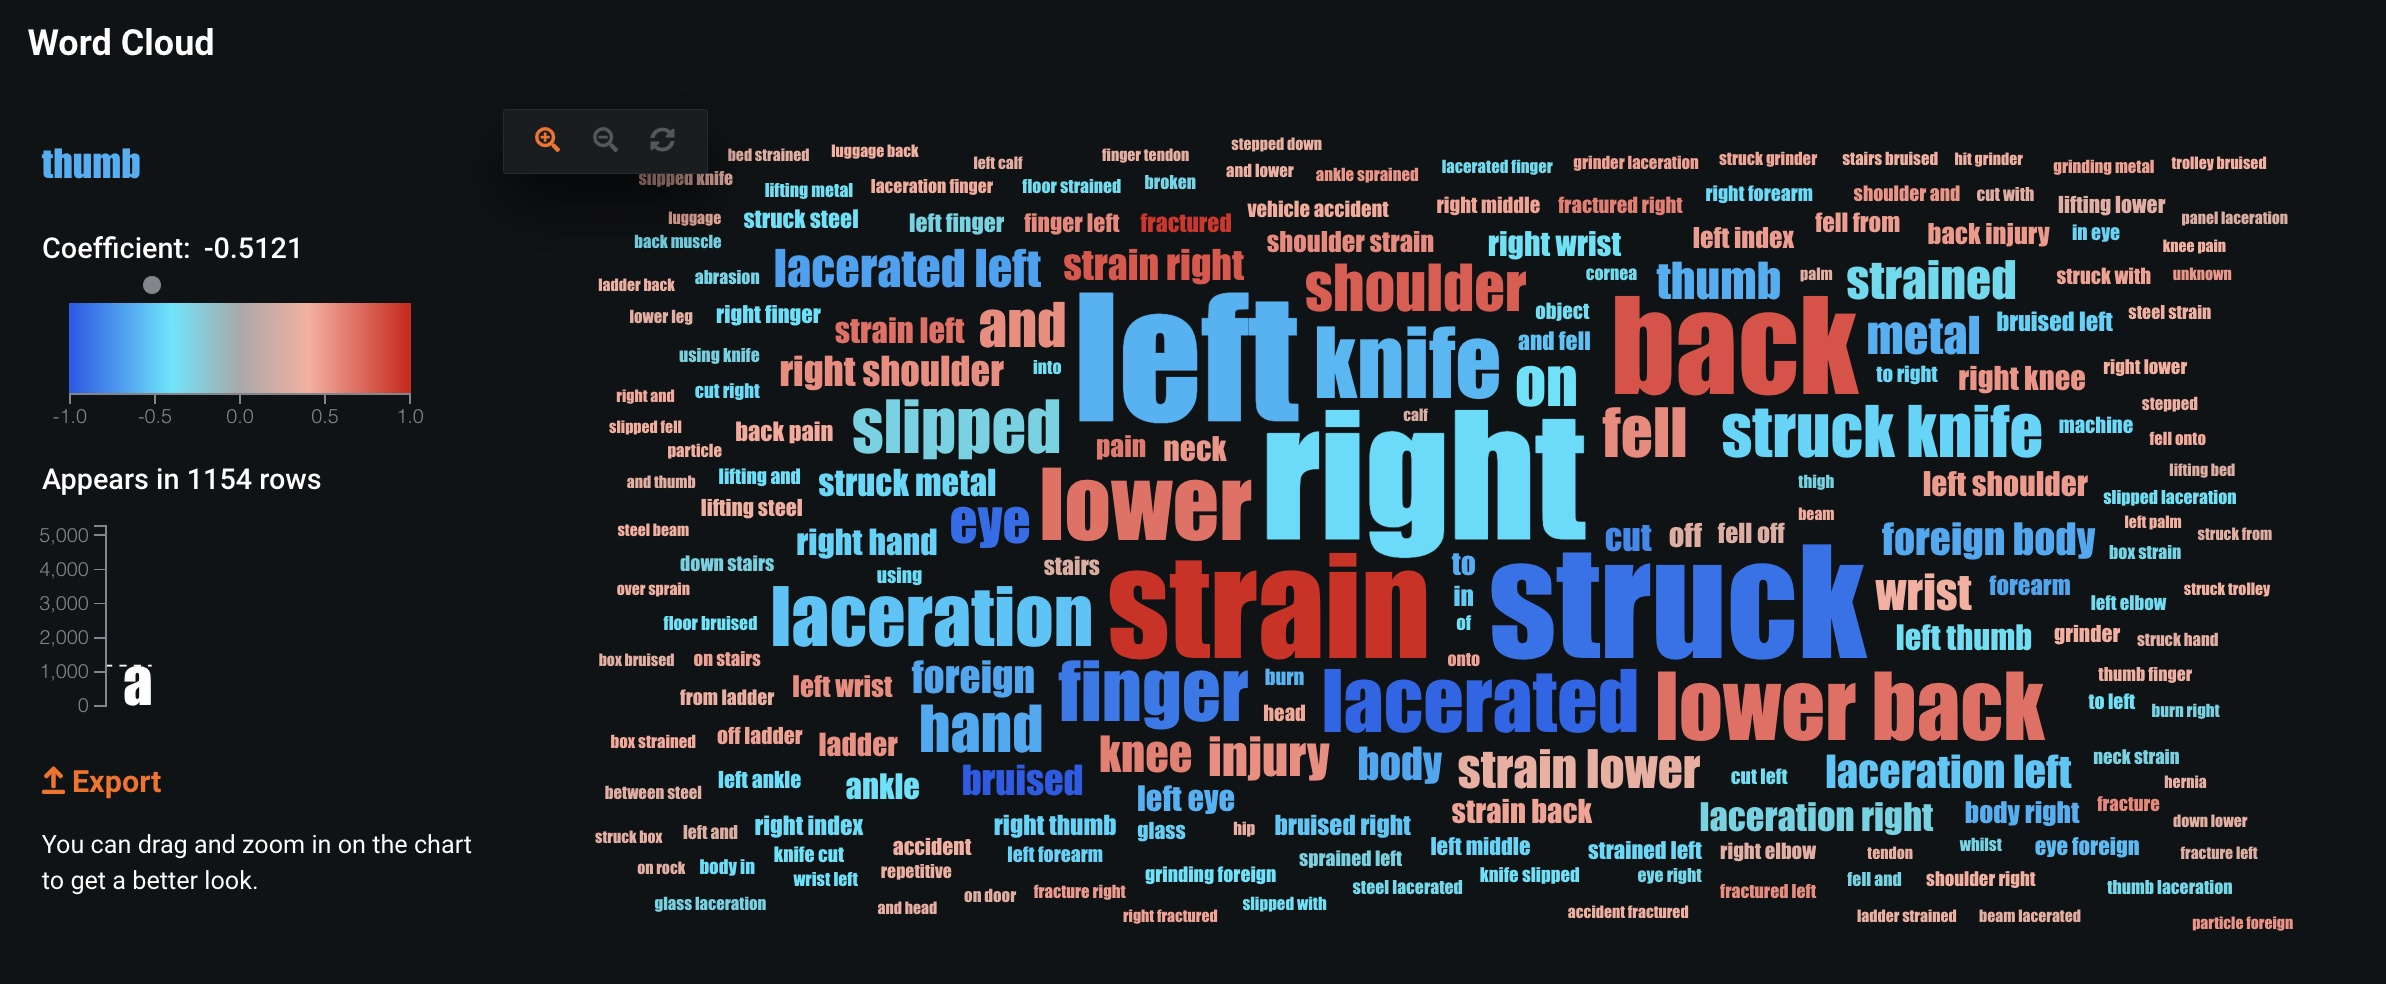

See the [DataRobot documentation](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/word-cloud.html) for more information on how to interpret this section.

### Select the top-performing model

DataRobot recommends models based on optimization metric scores. You can read about the [model recommendation process](https://docs.datarobot.com/en/docs/modeling/reference/model-detail/model-rec-process.html) for more details. 

In practice, the final selected model is based on a combination of accuracy, interpretability, and prediction time. This process could require multiple iterations. In this example, take the recommended model by DataRobot.

In [16]:
def sorted_by_metric(models, test_set, metric):
    models_with_score = [model for model in models if model.metrics[metric][test_set] is not None]

    return sorted(models_with_score, key=lambda model: model.metrics[metric][test_set])

In [17]:
# Unlock holdout and get the list of models trained
project.unlock_holdout()
models = project.get_models()

# Uncomment if this is not set when creating the project
metric = project.metric

# Get the top-performing model
model_top = sorted_by_metric(models, "holdout", metric)[0]

print(
    """The top performing model is {model} using metric, {metric}""".format(
        model=str(model_top), metric=metric
    )
)

The top performing model is Model('Light Gradient Boosting on ElasticNet Predictions (Gamma Loss)') using metric, Gamma Deviance


## Make predictions

### Test predictions

After determining the top-performing model from the Leaderboard, upload the prediction test dataset to verify that the model generates predictions successfully before deploying the model to a production environment. The predictions are returned as a Pandas dataframe. 

In [19]:
scoring_df = pd.read_csv("DR_Demo_Statistical_Case_Estimates_Scoring.csv")

prediction_dataset = project.upload_dataset(scoring_df)
predict_job = model_top.request_predictions(prediction_dataset.id)
prediction_dataset.id

predictions = predict_job.get_result_when_complete()
# pd.concat([scoring_df, predictions], axis=1)
results = pd.concat(
    [predictions.drop("row_id", axis=1), scoring_df.drop("Incurred", axis=1)], axis=1
)
results.head()

prediction  ReportingDelay  AccidentHour  Age  WeeklyRate Gender  \
0   7911.496925              36             5   31       243.0      F   
1    435.847855              33            13   20       390.1      M   
2     95.561120              22            10   24         0.0      M   
3  16776.450772              39            15   64       500.0      M   
4    104.522681              29            14   29         0.0      M   

  MaritalStatus  HoursWorkedPerWeek  DependentChildren  DependentsOther  \
0             M                  28                  0                0   
1             M                  38                  0                0   
2             S                   0                  0                0   
3             M                  38                  0                0   
4             M                   0                  0                0   

  PartTimeFullTime  DaysWorkedPerWeek DateOfAccident  \
0                F                  5         5/5/88   
1                F                  5        7/11/96   
2                F                  5     24/10/1994   
3                F                  5     13/09/2004   
4                F                  5         1/7/92   

                                    ClaimDescription ReportedDay  \
0     SLIPPED ON FLOOR FRACTURE RIGHT SHOULDER ELBOW        4Fri   
1  GRINDING FOREIGN BODY RIGHT LEG LACERATED RIGH...       1Tues   
2  STRUCK GLUE IN MACHINE LACERATION FINGERS LEFT...       1Tues   
3                      STRUCK LADDER LOWER BACK PAIN        4Fri   
4  STRUCK METAL FOREIGN BODY RIGHT THUMB AND RIGH...      3Thurs   

   InitialCaseEstimate  
0                 5000  
1                  700  
2                  110  
3                10000  
4                  210

### Deploy a model to production

After testing predictions, you can deploy it to a production environment and make predictions with [MLOps](https://docs.datarobot.com/en/mlops/index.html).  Deploying the model will free up workers, as data scored through the deployment doesn't use any modeling workers. Furthermore, you are no longer restricted on the amount of data to score; score over 100GB with the deployment. Deployments also offer many model management benefits: monitoring service, data drift, model comparison, retraining, and more.

In [ ]:
# Retrieve a prediction server
prediction_server = dr.PredictionServer.list()[0]

# Get the top performing model. Uncomment if this did not execute in the previous section
# model_top = sorted_by_metric(models, 'crossValidation', metric)[0]

deployment = dr.Deployment.create_from_learning_model(
    model_top.id,
    label="Insurance claim triage",
    description="Determine insurance claim severity",
    default_prediction_server_id=prediction_server.id,
)
deployment.id

### Configure batch predictions

After the model has been deployed, DataRobot creates an endpoint for real-time scoring. The deployment allows you to use DataRobot's batch prediction API to score large datasets with a deployed DataRobot model. 

The batch prediction API provides flexible intake and output options when scoring large datasets using prediction servers. The API is exposed through the DataRobot Public API and can be consumed using a REST-enabled client or Public API bindings for DataRobot's Python client.

#### Set the deployment ID

In [ ]:
deployment_id = "YOUR_DEPLOYMENT_ID"

#### Determine input and output options

DataRobot's batch prediction API allows you to score data from and to multiple sources. You can take advantage of the credentials and data sources you have already established previously through the UI for easy scoring. Credentials are usernames and passwords, while data sources are any databases with which you have previously established a connection (e.g., Snowflake). View the example code below outlining how to query credentials and data sources.

See the documentation for the full list of supported [input](https://docs.datarobot.com/en/docs/predictions/batch/batch-prediction-api/intake-options.html) and [output options](https://docs.datarobot.com/en/docs/predictions/batch/batch-prediction-api/output-options.html) and more information about [data connections](https://docs.datarobot.com/en/docs/data/connect-data/data-conn.html).

The snippet below shows how you can query all credentials tied to a DataRobot account.

In [ ]:
dr.Credential.list()

The output above returns multiple sets of credentials. The alphanumeric string included in each item of the list is the credentials ID. You can use that ID to access credentials through the API.

The snippet below shows how you can query all data sources tied to a DataRobot account. The second line lists each datastore with an alphanumeric string; that is the datastore ID.

In [ ]:
dr.DataStore.list()
print(dr.DataStore.list()[0].id)

### Scoring examples

The snippets below demonstrate how to score data with the Batch Prediction API. Edit the `intake_settings` and `output_settings` to suit your needs. You can mix and match until you get the outcome you prefer.

#### Score from CSV to CSV

In [ ]:
# Scoring without Prediction Explanations
if False:
    results_df = deployment.predict_batch(source=Path("inputfile.csv"))
    result_df.head()

#### Score from S3 to S3

In [ ]:
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            "type": "s3",
            "url": "s3://theos-test-bucket/lending_club_scoring.csv",  # Provide the URL of your datastore here
            "credential_id": "YOUR_CREDENTIAL_ID_FROM_ABOVE",  # Provide your credentials here
        },
        output_settings={
            "type": "s3",
            "url": "s3://theos-test-bucket/lending_club_scored2.csv",
            "credential_id": "YOUR_CREDENTIAL_ID_FROM_ABOVE",
        },
    )

#### Score from JDBC to JDBC

In [ ]:
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            "type": "jdbc",
            "table": "table_name",
            "schema": "public",
            "dataStoreId": data_store.id,  # Provide the ID of your datastore here
            "credentialId": cred.credential_id,  # Provide your credentials here
        },
        output_settings={
            "type": "jdbc",
            "table": "table_name",
            "schema": "public",
            "statementType": "insert",
            "dataStoreId": data_store.id,
            "credentialId": cred.credential_id,
        },
    )

## Model monitoring statistics

### Service Health

The scoring dataset used in this example only has 50 claims. Since this is the only prediction request for the deployment, the [**Service Health**](https://docs.datarobot.com/en/docs/mlops/monitor/service-health.html) tab indicates that 50 predictions are made along with other metrics that IT teams are often interested in.

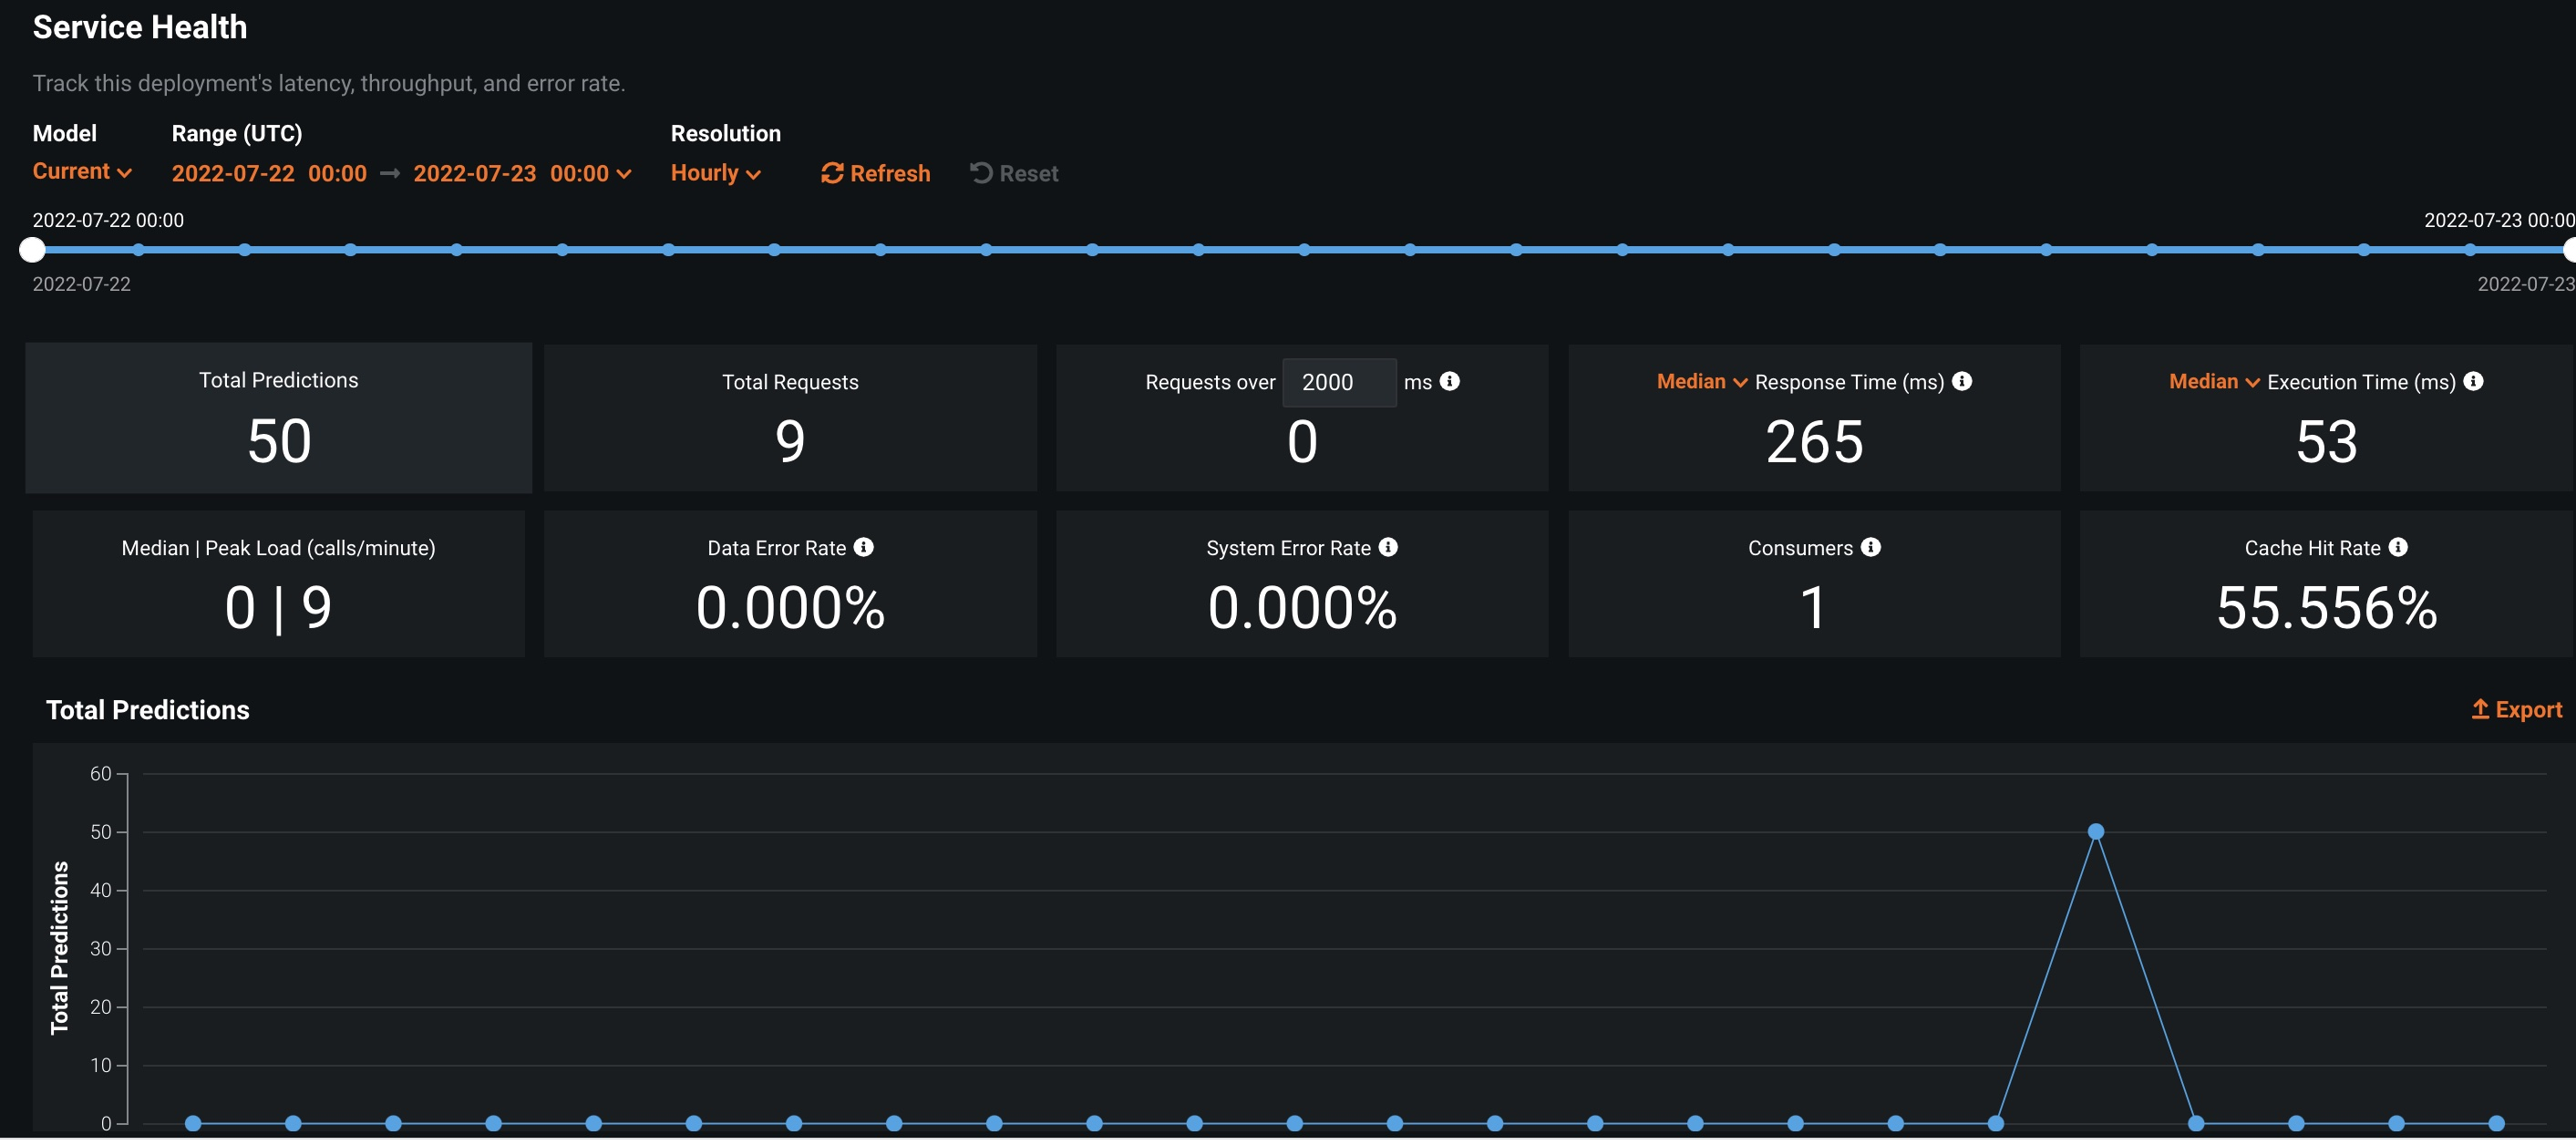



### Data Drift

The [Data Drift](https://docs.datarobot.com/en/docs/mlops/monitor/data-drift.html) tab provides interactive and exportable visualizations that help identify the potential data drift of the scoring data compared to the training data over a specified time interval. Severe data drift (marked as red on the left panel) should get immediate attention. Note: DataRobot suggests making at least 100 predictions for a reliable calculation of data drift; the 50 predictions used in this example may not lead to any solid conclusion.

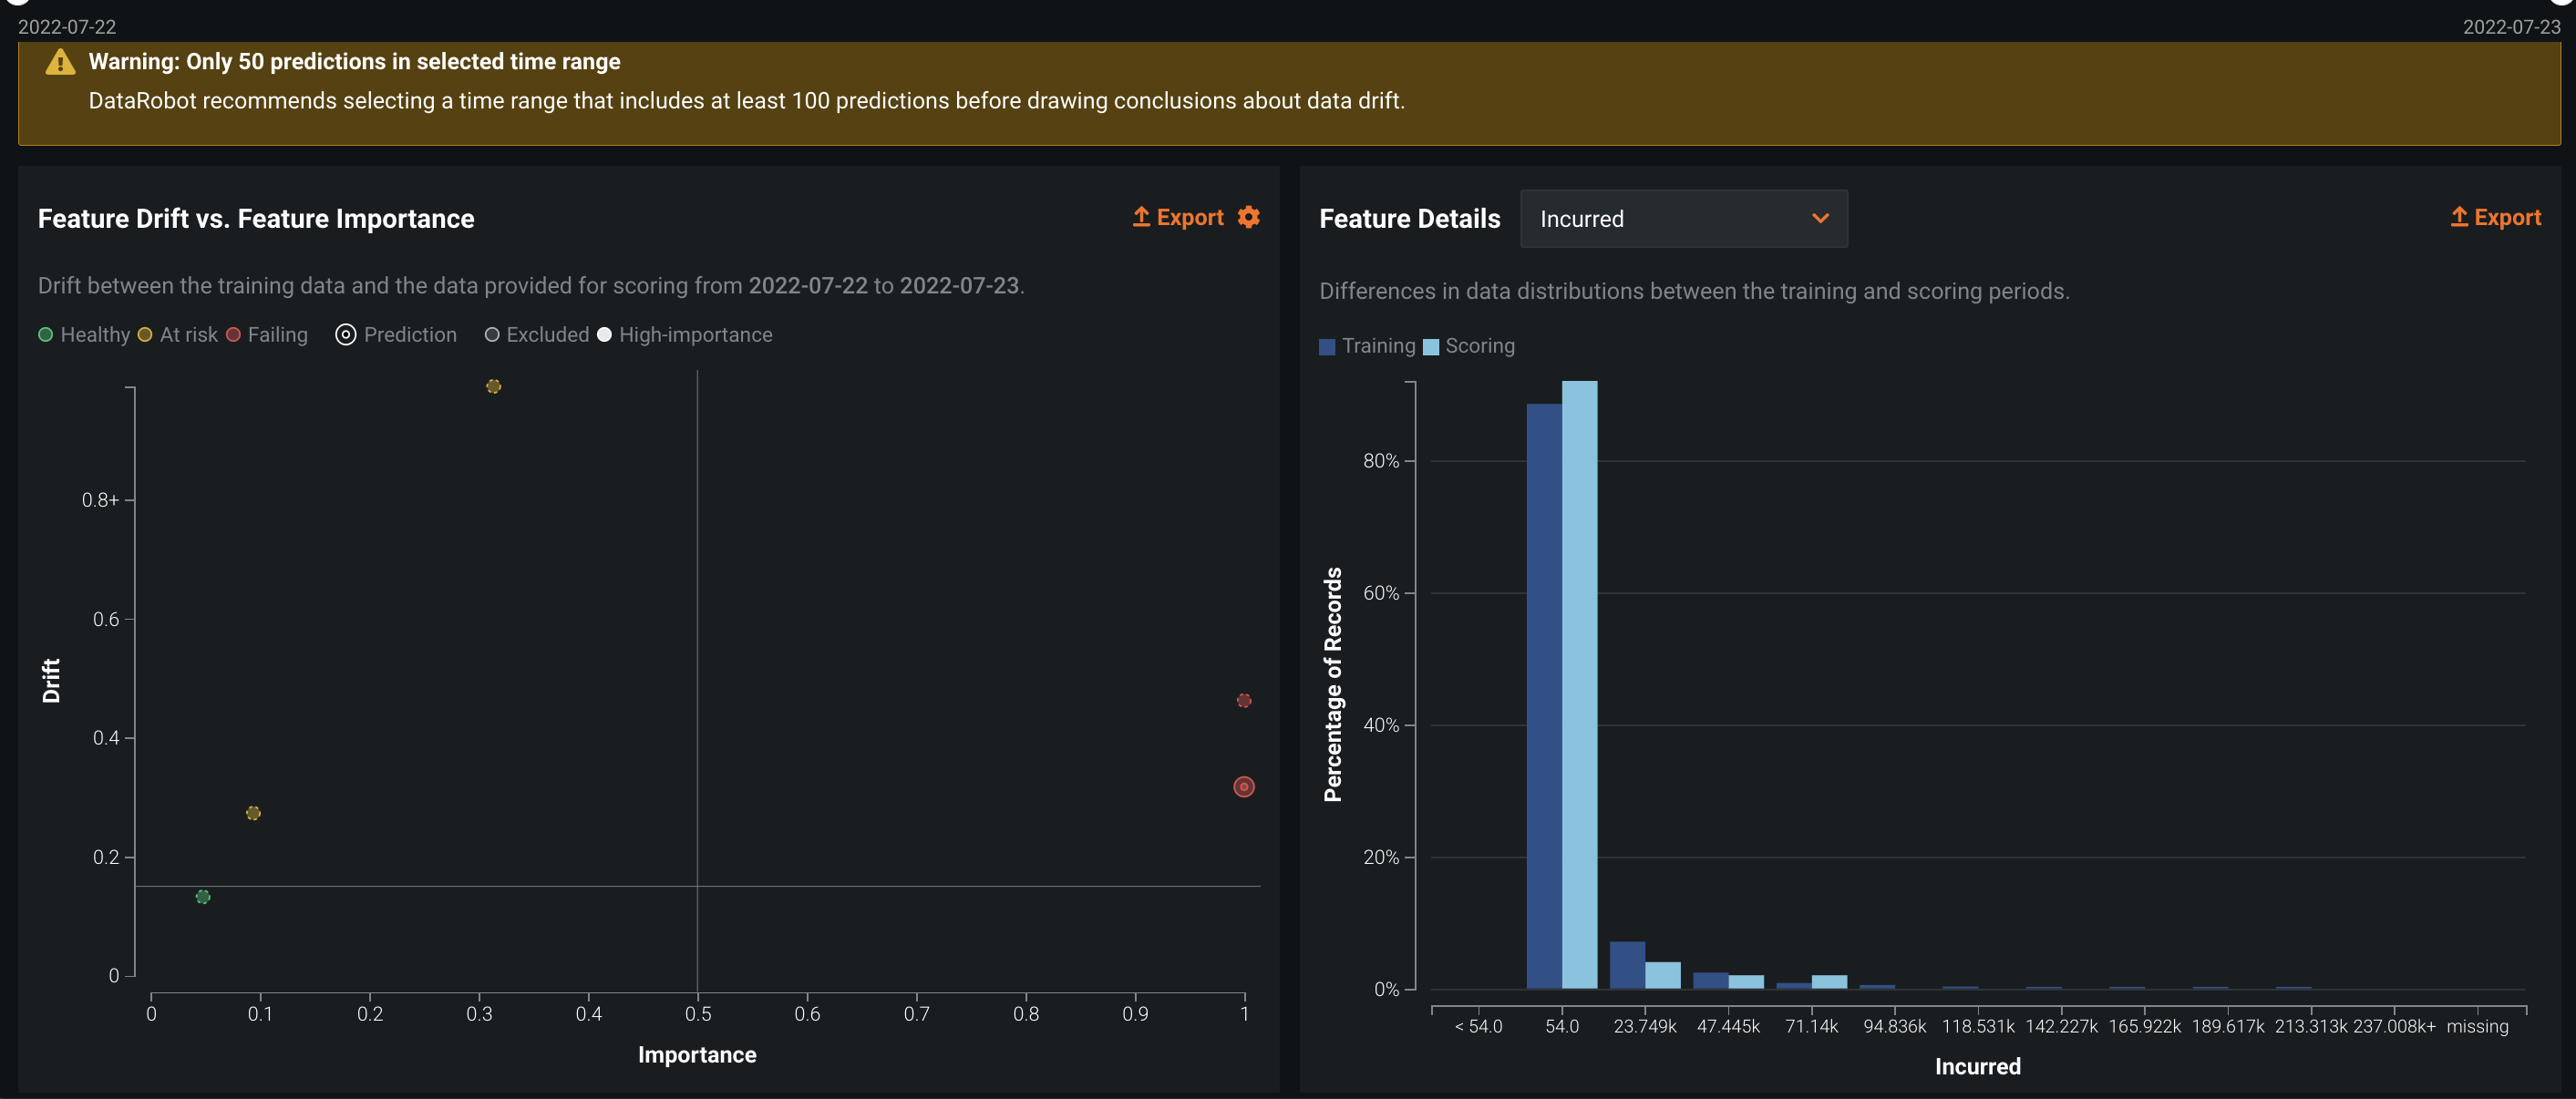